 ### Load the drive containing data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

### Defining function to group less represented parties under the 'Others' category

In [3]:
def creating_category_others(data):
  # Using 0.99 quantile to categorize 'Others'
  threshold_value = data['count'].quantile(0.99)
  values_below_thresh = data['count'] < threshold_value
  data.loc[values_below_thresh,'Label'] = 'Others'
  return data

## Loading datasets

In [4]:
# Load dataset containing sport quotes
dataset = pd.read_csv('/content/drive/MyDrive/ADA/ada-sports-quotes/sport-quotes-2017.csv.bz2', compression='bz2', usecols=['speaker','qids','quoteID'])

# Load speaker attributes from Google Drive
speaker_attributes = pd.read_parquet('/content/drive/MyDrive/ADA/Project datasets/speaker_attributes.parquet', columns=['nationality','party','id'])

# Load the database relating qids with wikidata labels
qid_labels = pd.read_csv('/content/drive/MyDrive/ADA/Project datasets/wikidata_labels_descriptions_quotebank.csv.bz2', compression='bz2', index_col='QID')

In [5]:
# Removing square brackets and quotation marks from qids to match the speaker_attributes dataset
dataset['qids'] = dataset['qids'].str.strip('[\'\']')
speakers = speaker_attributes[speaker_attributes['id'].isin(dataset['qids'])]

# Removing speakers without any known party (i.e. with 'party' == None)
politicians = speakers[~(speakers['party'].isna())]

## Computing the number of speakers per party from sport quotes

Only keeping the first qid for the 'party' feature. It is known, that it is not correct because we should select the party in which the speaker was at the time of the quote. This will be solved for Milestone 3, as this requires new speaker_features dataset to obtain this information. 

In [6]:
# Only keeping the first qid in the 'party' feature (with str.get(0))
# Counts the occurences of each party and adding the corresponding party label by merging qid_labels
party_speaker_counts_label = pd.DataFrame(pd.value_counts(politicians['party'].str.get(0))).merge(qid_labels, left_index=True, right_on='QID').rename(columns={'party': 'count'})

# Setting label of party with count lower than the 0.99 quantile to 'Others'
party_speaker_counts_label = creating_category_others(party_speaker_counts_label)

## Computing the number of quotes per party from sport quotes

In [7]:
# Selecting quotes from a speaker with a party and merging the speaker_attributes dataset
dataset_politicians_attributes = dataset[dataset['qids'].isin(politicians['id'])].merge(speaker_attributes, left_on='qids', right_on='id')
# Only keeping the first qid in the 'party' feature (with str.get(0))
dataset_politicians_attributes['party'] = dataset_politicians_attributes['party'].str.get(0)

# Counts the occurences of each party and add the corresponding party label 
party_quotes_counts_label = pd.DataFrame(pd.value_counts(dataset_politicians_attributes['party'])).merge(qid_labels, left_index=True, right_on='QID').rename(columns={'party': 'count'})

# Setting label of party with count lower than the 0.99 quantile to 'Others'
party_quotes_counts_label = creating_category_others(party_quotes_counts_label)

## Plots : pie plots and bar plots

Speaker's party distribution

Text(0.6, 0.92, "Speaker's party distribution of sport quotes for year 2017")

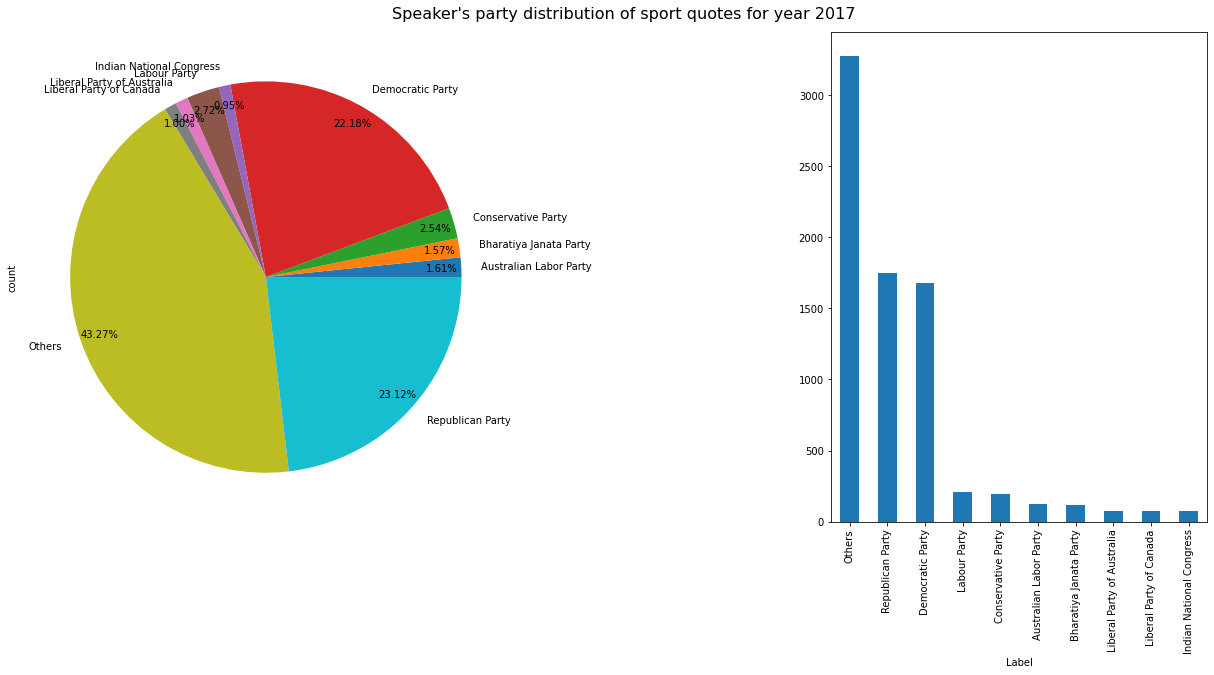

In [8]:
fig, axes = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]}, figsize=(27,9))

party_speaker_counts_label.groupby('Label').sum().plot(kind='pie', subplots=True, legend=False, autopct='%1.2f%%', ax=axes[0], pctdistance=0.90)
party_speaker_counts_label.groupby('Label').sum().sort_values(by='count', ascending=False).plot(kind='bar',legend=False, log=False, ax=axes[1])

plt.subplots_adjust(wspace=0)
fig.suptitle('Speaker\'s party distribution of sport quotes for year 2017', fontsize=16, x=0.6, y=0.92)

Quote's party distribution

Text(0.6, 0.92, "Quote's party distribution of sport quotes for year 2017")

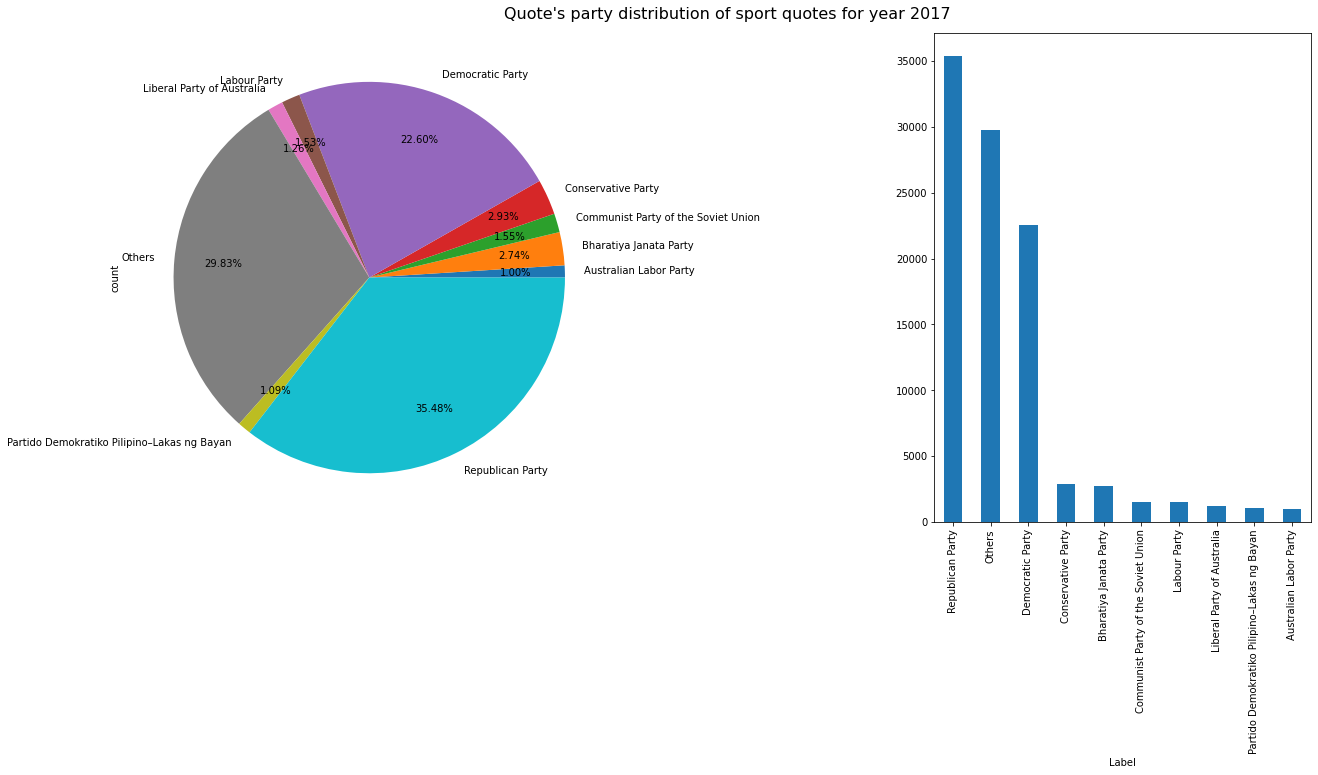

In [9]:
fig, axes = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]}, figsize=(27,9))

party_quotes_counts_label.groupby('Label').sum().plot(kind='pie', subplots=True, legend=False, autopct='%1.2f%%', ax=axes[0], pctdistance=0.75)
party_quotes_counts_label.groupby('Label').sum().sort_values(by='count', ascending=False).plot(kind='bar',legend=False, log=False, ax=axes[1])

plt.subplots_adjust(wspace=0)
fig.suptitle('Quote\'s party distribution of sport quotes for year 2017', fontsize=16, x=0.6, y=0.92)

## Data description and overview

Lengths of DataFrame (i.e. number of sample)

In [10]:
print('Number of sport quotes: {q_sport}\nNumber of political quotes: {q_pol}\nNumber of speakers: {spea}\nNumber of politicians (i.e. speakers with political party): {pol}\nNumber of different parties: {part}'\
      .format(q_sport=dataset.shape[0], spea=speakers.shape[0], pol=politicians.shape[0], part=party_speaker_counts_label.shape[0], q_pol=dataset_politicians_attributes.shape[0]))

Number of sport quotes: 4621534
Number of political quotes: 99647
Number of speakers: 91138
Number of politicians (i.e. speakers with political party): 7569
Number of different parties: 869


In [11]:
dataset.sample(5)

,quoteID,speaker,qids
4492709,2017-11-06-070293,Dave Cox,Q5228596
3426702,2017-06-14-111781,Aron Price,Q4795542
1641104,2017-08-27-004128,Sam Darnold,Q27049069
34039,2017-09-14-115459,Paul Johnson,"Q15051763', 'Q1632997', 'Q18607331', 'Q1956088..."
3168278,2017-08-31-058285,Nick Wright,"Q10399189', 'Q10413152', 'Q16143219', 'Q570182..."


In [12]:
speakers.sample(5)

,nationality,party,id
7372978,None,None,Q58159667
2467305,[Q145],None,Q7563011
3722600,None,None,Q17489576
8064634,[Q30],None,Q5216298
2275586,[Q30],None,Q235196


In [13]:
politicians.sample(5)

,nationality,party,id
313644,[Q30],[Q29552],Q16729478
5762882,[Q30],[Q29552],Q3613493
5862091,[Q30],[Q29552],Q7612851
3779180,[Q924],[Q652091],Q22279305
5792945,[Q30],[Q29552],Q4946593


In [14]:
party_speaker_counts_label.head(5)

,count,Label,Description
QID,,,
Q29468,1750,Republican Party,major political party in the United States
Q29552,1679,Democratic Party,political party in the United States
Q9630,206,Labour Party,political party in the United Kingdom
Q9626,192,Conservative Party,political party in the United Kingdom
Q216082,122,Australian Labor Party,political party in Australia


In [15]:
dataset_politicians_attributes.sample(5)

,quoteID,speaker,qids,nationality,party,id
91854,2017-09-16-030817,Hong Lim,Q16145445,"[Q408, Q424]",Q25210911,Q16145445
24284,2017-04-30-039728,John Elway,Q432931,[Q30],Q29468,Q432931
47079,2017-06-29-097618,Pam Shriver,Q54654,[Q30],Q29468,Q54654
96714,2017-08-13-043559,Guy Molinari,Q59335,[Q30],Q29468,Q59335
67209,2017-11-07-136796,Dina Titus,Q524440,[Q30],Q29552,Q524440


In [16]:
party_quotes_counts_label.head(5)

,count,Label,Description
QID,,,
Q29468,35352,Republican Party,major political party in the United States
Q29552,22523,Democratic Party,political party in the United States
Q9626,2920,Conservative Party,political party in the United Kingdom
Q10230,2728,Bharatiya Janata Party,major political party in India
Q79854,1545,Communist Party of the Soviet Union,political party founded in 1912
